# Analyzing customer support on Twitter
### Author: Qian Li

### Data problem:
Kaggle has customer support conversation dataset which includes 3 million tweets and can be accessed here (https://www.kaggle.com/thoughtvector/customer-support-on-twitter). The purpose of the project is to understand what questions customers and ask and how to respond to them.

#### I put together a data dictionary here:
- tweet_id: id of each tweet
- author_id: id of author
- inbound: True if it was tweeted to companies by customers and False the other way round
- created_at: tweet created time
- text: content of the tweet
- in_response_to_tweet_id: If this tweet was responding to a previous tweet, then the value is the id of previous tweet, otherwise, NaN
- response_tweet_id: If this tweet was responded by a later tweet, then the value is the id of replying tweet, otherwise, NaN


### Data cleaning and reshaping
Columns such inbound and in_response_to_tweet_id helps us to identify questions and answers. As the conversations can go through several rounds of tweets, only first question/comment and response pairs will be pulled out to analysis. 

### 1. Some visualizations
Including tweets count and sentiment analysis on @AmazonHelp channel, compared with @AppleSupport.

### 2. Comparison between results of different Topic Modeling methods (NMF and LDA) 
Topic modeling is only done on @AmazonHelp channel.

NMF overperforms LDA in analyzing tweets and I summerized the top 10 topics in tweets going to AmazonHelp.

### 3. Prediting a response for a user's initial question/comment (seq2seq)
on all channels.

### Loading libraries

In [304]:
import re
import string
import random
import time
import pandas as pd
import nltk
import numpy as np
import enchant

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words
import sklearn.feature_extraction.text as text

from nltk.tokenize import casual_tokenize
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt

### Loading Data

In [480]:
tweets = pd.read_csv('data/twcs.csv')
tweets.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [470]:
tweets.dtypes

tweet_id                     int64
author_id                   object
inbound                       bool
created_at                  object
text                        object
response_tweet_id           object
in_response_to_tweet_id    float64
dtype: object

In [466]:
tweets.shape

(2811774, 7)

In [467]:
tweets.inbound.value_counts()

True     1537843
False    1273931
Name: inbound, dtype: int64

In [468]:
tweets.created_at.min(), tweets.created_at.max()

('Fri Apr 01 17:37:48 +0000 2016', 'Wed Sep 28 18:06:15 +0000 2016')

# 1. Some Visualizations - Tweet counts by brand

In [414]:
tweet_to_company = tweets.text.apply(lambda txt: re.search('(\W@|^@)([a-zA-Z_]+)', txt).group().strip() 
                                    if re.search('(\W@|^@)([a-zA-Z_]+)', txt) else None)
tweet_by_brand = tweet_to_company.value_counts().head(10)

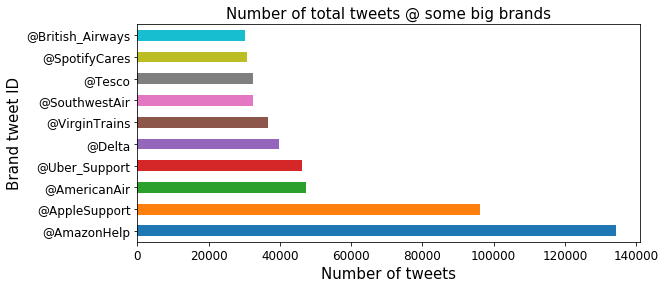

In [464]:
tweet_by_brand.plot('barh',figsize = (9,4),fontsize = 12)
plt.xlabel('Number of tweets',fontsize = 15)
plt.ylabel('Brand tweet ID',fontsize = 15)
plt.title('Number of total tweets @ some big brands', fontsize = 15);

### Reshaping to initial question and reponse pairs

In [9]:
# find the initial question/comment to the companies
first_inbound = tweets[pd.isnull(tweets.in_response_to_tweet_id) & tweets.inbound]

# join initial question with its response
inbounds_and_outbounds = pd.merge(first_inbound, tweets, left_on='tweet_id', 
                                  right_on='in_response_to_tweet_id').sample(frac=1)
inbounds_and_outbounds = inbounds_and_outbounds[inbounds_and_outbounds.inbound_y ^ True]

In [10]:
inbounds_and_outbounds.to_csv("data/inbounds_and_outbounds.csv")

In [5]:
inbounds_and_outbounds.shape

(794299, 14)

In [322]:
inbounds_and_outbounds.head(2)

,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
130277,497044,233605,True,Fri Dec 01 15:13:46 +0000 2017,@XboxSupport hello please help,"497043,497045",NaN,497043,XboxSupport,False,Fri Dec 01 18:37:35 +0000 2017,@233605 are having along with your Gamertag? P...,NaN,497044.0
586607,2051557,606707,True,Thu Oct 05 20:30:18 +0000 2017,My iPhone keeps glitching after the new update...,2051556,NaN,2051556,AppleSupport,False,Thu Oct 05 21:28:00 +0000 2017,@606707 Let's talk. Have you updated to iOS 11...,NaN,2051557.0


In [343]:
inbound_by_brand = inbounds_and_outbounds.text_x.apply(lambda txt: re.search('(\W@|^@)([a-zA-Z_]+)', txt).group().strip() 
                                    if re.search('(\W@|^@)([a-zA-Z_]+)', txt) else None)

In [379]:
tweet_count = inbound_by_brand.value_counts().head(10)

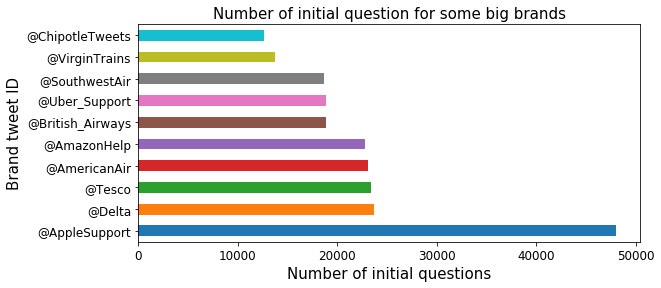

In [463]:
tweet_count.plot('barh',figsize = (9,4),fontsize = 12)
plt.xlabel('Number of initial questions',fontsize = 15)
plt.ylabel('Brand tweet ID',fontsize = 15)
plt.title('Number of initial question for some big brands', fontsize = 15);

One thing I learn comparing from the two plots is that AmazonHelp for instance doesn't have the most number of initial questions/comments, but the conversation are most active. One possible explaination is that Amazon has a wide range of different services and it is the largest online ecommerce. 

So I'm interested what kind of questions people ask @AmazonHelp.

# Sentiment Analysis

In [431]:
tweet_to_amazon = tweets.text.apply(lambda txt: txt if re.search('(\W@|^@)(@AmazonHelp)', txt) else None)
tweet_to_amazon = tweet_to_amazon[tweet_to_amazon.notnull()]

In [439]:
def sentiment(text):
    Sentim_analyser = SentimentIntensityAnalyzer()
    return Sentim_analyser.polarity_scores(text)['compound']

In [444]:
amazon_score = tweet_to_amazon.apply(sentiment)

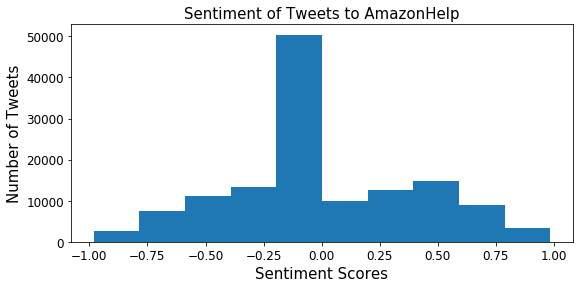

In [545]:
amazon_score.plot('hist',figsize = (9,4),fontsize = 12)
plt.xlabel('Sentiment Scores',fontsize = 15)
plt.ylabel('Number of Tweets',fontsize = 15)
plt.title('Sentiment of Tweets to AmazonHelp', fontsize = 15);

In [497]:
tweet_to_apple = tweets.text.apply(lambda txt: txt if re.search('(\W@|^@)(AppleSupport)', txt) else None)
tweet_to_apple = tweet_to_apple[tweet_to_apple.notnull()]
apple_score = tweet_to_apple.apply(sentiment)

In [542]:
len(amazon_score[amazon_score==0]), len(apple_score[apple_score==0])

(44609, 33902)

In [556]:
tweet_to_amazon.head()

182        @AmazonHelp ありがとうございます。\n今、電話で主人が対応していただいてます。
183    @AmazonHelp 電話で対応してもらいましたが改良されませんでした。\n保証期間も過ぎ...
185                        @AmazonHelp こちらこそありがとうございました。
322    @AmazonHelp 3 different people have given 3 di...
324    @AmazonHelp I frankly don't have the patience ...
Name: text, dtype: object

As there are so many zeros, I'm suspicious that many texts are in foreign languages and thus can not be analyzed by vaderSentiment. So zeros values will be deleted in below comparison.

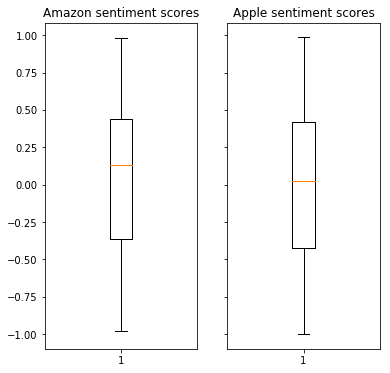

In [541]:
fig, axes = plt.subplots(ncols=2, figsize=(6, 6), sharey=True)
axes[0].boxplot(amazon_score[amazon_score!=0])
axes[0].set_title('Amazon sentiment scores')
axes[1].boxplot(apple_score[apple_score!=0])
axes[1].set_title('Apple sentiment scores');

AmazonHelp in overall, has lightly more positive comments than AppleSupport.

# 2. Topic Modeling methods (NMF and LDA)
### Tokenizing tweets @AmazonHelp

In [225]:
amazonhelp = inbounds_and_outbounds[inbounds_and_outbounds['text_x'].str.contains("@AmazonHelp")]
#amazonhelp.to_csv("data/amazonhelp.csv")
amazonhelp.head()

,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
161468,602351,156041,True,Sun Dec 03 21:39:12 +0000 2017,@AmazonHelp Hello. If I cancel an order that w...,602349,NaN,602349,AmazonHelp,False,Sun Dec 03 21:43:57 +0000 2017,"@156041 Great question, Chris! All Amazon refu...",602350,602351.0
234724,868091,326112,True,Fri Oct 13 15:13:35 +0000 2017,@AmazonHelp why is it so hard to change my pay...,868090,NaN,868090,AmazonHelp,False,Fri Oct 13 15:20:00 +0000 2017,@326112 I'm sorry for the troubles changing th...,NaN,868091.0
435160,1574467,485228,True,Tue Oct 17 06:28:51 +0000 2017,"@AmazonHelp my orders aren't showing up, i tri...",1574466,NaN,1574466,AmazonHelp,False,Tue Oct 17 06:31:00 +0000 2017,"@485228 Sorry to hear that, do you use https:/...",1574465,1574467.0
828310,2834260,788980,True,Mon Nov 27 14:15:24 +0000 2017,"@AmazonHelp Hey Amazon, one of your deals of t...",2834258,NaN,2834258,AmazonHelp,False,Mon Nov 27 14:22:00 +0000 2017,"@788980 Hi, we don't have info as to when this...",2834259,2834260.0
620170,2153981,632891,True,Mon Nov 20 15:34:58 +0000 2017,@AmazonHelp you guys just keep raising the bar...,2153978,NaN,2153978,AmazonHelp,False,Mon Nov 20 16:26:00 +0000 2017,@632891 I'm sorry for any inconvenience! We're...,"2153979,2153980",2153981.0


In [12]:
# remove tags
tags = re.compile('(\W@|^@)([a-zA-Z0-9_]+)')
x_text_amazon = amazonhelp.text_x.apply(lambda txt: tags.sub('', txt).strip())
y_text_amazon = amazonhelp.text_y.apply(lambda txt: tags.sub('', txt).strip())

In [288]:
def tokenize(text):
    """
    Tokenize text and return a list of tokenized words found in the text. 
    Normalize to lowercase, remove stop words, drop words of length < 3.
    """ 
    d = enchant.Dict("en_US")
    text = re.sub('https?://[A-Za-z0-9./]+','',text)
    words = TextBlob(text).words.lower()
    words = [re.sub('[0-9-]+','',w) for w in words if w.isalpha()]
    words = [w for w in words if d.check(w)]
    words = [w for w in words if len(w) > 2]
    words = [w for w in words if w not in stop_words.ENGLISH_STOP_WORDS]
    return words

def filterEnglish(words):
    n = len(words)
    y = [d.check(w) for w in words]
    if sum(y)> 0.5*n:
        return ' '.join(words)
    else:
        return ''

def tokenizer(text):
    return filterEnglish(tokenize(text))

In [289]:
tokenized_question_amazon = x_text_amazon.apply(tokenizer)

#### Compare before and after tokenizer

In [290]:
x_text_amazon.head()

161468    Hello. If I cancel an order that was back orde...
234724    why is it so hard to change my payment to the ...
435160    my orders aren't showing up, i tried logging o...
828310    Hey Amazon, one of your deals of the day is no...
620170    you guys just keep raising the bar. I tweet be...
Name: text_x, dtype: object

In [291]:
tokenized_question_amazon.head()

161468    hello cancel order ordered taken money account...
234724        hard change payment gift card option checkout
435160         orders showing tried logging showing worried
828310    hey amazon deals day available purchase kindle...
620170    guys just raising bar tweet frustrated usual s...
Name: text_x, dtype: object

### (1) Topic modeling with Non-negative matrix factorization

In [292]:
vectorizer = text.CountVectorizer(input='content', stop_words='english',max_df = 500, min_df=10)
dtm = vectorizer.fit_transform(tokenized_question_amazon).toarray()
vocab = np.array(vectorizer.get_feature_names())

In [409]:
vocab['return']

6022

In [410]:
vocab['delay']

2071

In [293]:
dtm.shape

(23142, 1786)

In [294]:
from sklearn import decomposition
num_topics = 10
num_top_words = 20
nmf = decomposition.NMF(n_components=num_topics, random_state=1)
doctopic = nmf.fit_transform(dtm)

In [295]:
topic_words = []

for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([vocab[i] for i in word_idx])

In [296]:
topics_nmf = [', '.join(words) for words in topic_words]

### (2) Topic modeling with Latent Dirichlet allocation (LDA)

In [209]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=num_topics, max_iter=5, learning_method='online', 
                                learning_offset=50.,random_state=0).fit(dtm)


In [212]:
topic_words_lda = []

for topic in lda.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words_lda.append([vocab[i] for i in word_idx])
topics_lda = [', '.join(words) for words in topic_words_lda]

### (3) Results
Reading the top 20 words from each topic, compare which result makes more sense.

In [213]:
# LDA
for topic_index in range(len(topics_lda)):
    print("Topic %02d: %s" % ( topic_index+1, topics_lda[topic_index] ) )

Topic 01: cancel, use, courier, say, hello, make, team, support, working, don, told, products, website, fix, sure, option, haven, great, locked, using
Topic 02: number, problem, seller, ship, thank, came, possible, happy, para, stock, info, logistics, pickup, reason, packaging, broken, second, ups, open, leave
Topic 03: address, tomorrow, pas, code, bonjour, times, pour, est, details, change, access, password, changed, coming, offer, site, thing, case, guy, attempt
Topic 04: saying, waiting, week, orders, membership, going, placed, kindle, book, worst, come, purchase, ago, charged, showing, tried, message, happened, bad, twice
Topic 05: supposed, late, packages, left, home, receive, door, driver, services, place, lost, person, arrive, house, unable, business, morning, idea, going, things
Topic 06: items, said, tell, send, able, free, arrived, phone, months, paying, different, new, let, member, damaged, used, hours, purchased, replacement, music
Topic 07: check, mail, look, die, having,

In [297]:
# NMF
for topic_index in range(len(topics_nmf)):
    print("Topic %02d: %s" % ( topic_index+1, topics_nmf[topic_index] ) )

Topic 01: arrive, supposed, going, date, tomorrow, shipped, tracking, week, arrived, paid, ago, told, delayed, placed, dispatched, late, expected, come, till, guaranteed
Topic 02: card, gift, credit, balance, payment, use, code, used, buy, using, purchase, details, cards, add, debit, charged, paid, hello, told, visa
Topic 03: phone, number, new, mobile, problem, receive, using, minutes, trying, chat, spent, team, promised, calls, use, given, replacement, courier, asap, box
Topic 04: address, wrong, sent, change, password, changed, number, correct, code, billing, send, different, tried, mail, instead, use, shipped, placed, old, business
Topic 05: pas, est, pour, bonjour, plus, par, site, comment, mail, possible, encore, temps, normal, mes, car, aux, point, code, client, payer
Topic 06: items, box, week, charged, missing, sent, showing, returned, shipped, paying, ago, purchased, stock, member, placed, twice, ship, damaged, different, price
Topic 07: cancel, way, kindle, trying, buy, memb

A lot of topic words from LDA don't form a meaning. The result of NMF makes more sense in this case but a few topic is also talking about various things.

### (4) 10 Topics summarized from NMF method

### Top 10 topics:
1. placed order - shipping/delivery time
2. payment method (credit/gift card)
3. phone number (missing?)
4. wrong address /personal information changed
5. unknown (foreign language)
6. received product issue (items missing, damaged, returned, etc)
7. cancellation, kindle/membership
8. really disappointed of service (what amazon said, packages late, etc)
9. delay in order
10. customer support channel

Check out one example below

In [221]:
print(x_text_amazon.iloc[1])

why is it so hard to change my payment to the gift card option at checkout?


In [231]:
# normalize score
doctopic = doctopic / ((np.sum(doctopic, axis=1, keepdims=True))+ 0.01)

print(doctopic[1])
print("This question is most related to topic %d" %(np.argmax(doctopic[1])+1))

[0.00000000e+00 8.36907491e-01 0.00000000e+00 7.52372132e-02
 0.00000000e+00 0.00000000e+00 5.67753568e-02 0.00000000e+00
 4.03589777e-04 0.00000000e+00]
This question is most related to topic 2


In [300]:
x_text_amazon.iloc[2]

"my orders aren't showing up, i tried logging out then back in but they're not showing up at all. im worried."

In [257]:
print("This question is most related to topic %d" %(np.argmax(doctopic[2])+1))

This question is most related to topic 9


# 3. Prediting a response for a user's initial question/comment (seq2seq)
#### Not much tokenizing is done since I want to put raw texts to the model

In [372]:
# remove @ID tags
tags = re.compile('(\W@|^@)([a-zA-Z0-9_]+)')
x_text = inbounds_and_outbounds.text_x.apply(lambda txt: tags.sub('', txt).strip())
y_text = inbounds_and_outbounds.text_y.apply(lambda txt: tags.sub('', txt).strip())

In [375]:
# create a dictionary matching a numeric number with a word
count_vec = CountVectorizer(tokenizer=casual_tokenize, max_features=MAX_VOCAB_SIZE - 3)
count_vec.fit(x_text + y_text)
analyzer = count_vec.build_analyzer()
vocab = {k: v + 3 for k, v in count_vec.vocabulary_.items()}
reverse_vocab = {v: k for k, v in vocab.items()}

In [363]:
# creating sentence of equal length padded with 1 if length is shorter than 30
def to_word_idx(sentence):
    # from word to indices
    full_length = [vocab.get(tok, UNK) for tok in analyzer(sentence)] + [PAD] * MAX_MESSAGE_LEN
    return full_length[:MAX_MESSAGE_LEN]

def from_word_idx(word_idxs):
    # from indices to word
    return ' '.join(reverse_vocab[idx] for idx in word_idxs if idx > PAD).strip()

In [11]:
x = pd.np.vstack(x_text.apply(to_word_idx).values)
y = pd.np.vstack(y_text.apply(to_word_idx).values)

In [12]:
# Use simple random split of data - may cause class imbalance!
all_idx = list(range(len(x)))
train_idx = set(random.sample(all_idx, int(0.8 * len(all_idx))))
test_idx = {idx for idx in all_idx if idx not in train_idx}

train_x = x[list(train_idx)]
test_x = x[list(test_idx)]
train_y = y[list(train_idx)]
test_y = y[list(test_idx)]

print(f'Training data of shape {train_x.shape} and test data of shape {test_x.shape}.')

Training data of shape (635439, 30) and test data of shape (158860, 30).


### Save all data that needed to train the model and upload to AWS if you want to run on AWS.

In [13]:
np.save("/data/train_x", train_x)
np.save("/data/test_x", test_x)
np.save("/data/train_y", train_y)
np.save("/data/test_y", test_y)

In [349]:
train_x = np.load('data/train_x.npy')
train_y = np.load('data/train_y.npy')
test_x = np.load('data/test_x.npy')
test_y = np.load('data/test_y.npy')

x_text = np.load("data/x_text.npy")
y_text = np.load("data/y_text.npy")

reverse_vocab = np.load('data/reverse_vocab.npy').item()

### Model Creation

In [367]:
MAX_VOCAB_SIZE = 2**13
MAX_MESSAGE_LEN = 30
UNK = 0
PAD = 1
START = 2
EMBEDDING_SIZE = 100
CONTEXT_SIZE = 100
BATCH_SIZE = 1
DROPOUT = 0.2
LEARNING_RATE=0.005

In [365]:
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.layers import Dense, Input, GRU, Dropout, Embedding, RepeatVector, concatenate, \
    TimeDistributed
from keras.utils import np_utils

In [368]:
def create_model():
    shared_embedding = Embedding(
        output_dim=EMBEDDING_SIZE,
        input_dim=MAX_VOCAB_SIZE,
        input_length=MAX_MESSAGE_LEN,
        name='embedding',
    )
    
    # ENCODER
    
    encoder_input = Input(
        shape=(MAX_MESSAGE_LEN,),
        dtype='int32',
        name='encoder_input',
    )
    
    embedded_input = shared_embedding(encoder_input)
    
    encoder_rnn = GRU(
        CONTEXT_SIZE,
        name='encoder',
        dropout=DROPOUT
    )
    
    context = RepeatVector(MAX_MESSAGE_LEN)(encoder_rnn(embedded_input))
    
    # DECODER
    
    last_word_input = Input(
        shape=(MAX_MESSAGE_LEN, ),
        dtype='int32',
        name='last_word_input',
    )
    
    embedded_last_word = shared_embedding(last_word_input)
    decoder_input = concatenate([embedded_last_word, context], axis=2)
    
    decoder_rnn = GRU(
        CONTEXT_SIZE,
        name='decoder',
        return_sequences=True,
        dropout=DROPOUT
    )
    
    decoder_output = decoder_rnn(decoder_input)
    
    next_word_dense = TimeDistributed(
        Dense(int(MAX_VOCAB_SIZE / 2), activation='relu'),
        name='next_word_dense',
    )(decoder_output)
    
    next_word = TimeDistributed(
        Dense(MAX_VOCAB_SIZE, activation='softmax'),
        name='next_word_softmax'
    )(next_word_dense)
    
    return Model(inputs=[encoder_input, last_word_input], outputs=[next_word])

s2s_model = create_model()
optimizer = Adam(lr=LEARNING_RATE, clipvalue=5.0)
s2s_model.compile(optimizer='adam', loss='categorical_crossentropy')

### Model training

In [369]:
def add_start_token(y_array):
    return np.hstack([
        START * np.ones((len(y_array), 1)),
        y_array[:, :-1],
    ])

def binarize_labels(labels):
    return np.array([np_utils.to_categorical(row, num_classes=MAX_VOCAB_SIZE)
                     for row in labels])

def respond_to(model, text):
    input_y = add_start_token(PAD * np.ones((1, MAX_MESSAGE_LEN)))
    idxs = np.array(to_word_idx(text)).reshape((1, MAX_MESSAGE_LEN))
    for position in range(MAX_MESSAGE_LEN - 1):
        prediction = model.predict([idxs, input_y]).argmax(axis=2)[0]
        input_y[:,position + 1] = prediction[position]
    return from_word_idx(model.predict([idxs, input_y]).argmax(axis=2)[0])

In [370]:
def train_mini_epoch(model, start_idx, end_idx):
    """ Batching seems necessary in Kaggle Jupyter Notebook environments, since
        `model.fit` seems to freeze on larger batches (somewhere 1k-10k).
    """
    b_train_y = binarize_labels(train_y[start_idx:end_idx])
    input_train_y = add_start_token(train_y[start_idx:end_idx])
    
    model.fit(
        [train_x[start_idx:end_idx], input_train_y], 
        b_train_y,
        epochs=1,
        batch_size=BATCH_SIZE,
    )
    
    rand_idx = random.sample(list(range(len(test_x))), SUB_BATCH_SIZE)
    print('Test results:', model.evaluate(
        [test_x[rand_idx], add_start_token(test_y[rand_idx])],
        binarize_labels(test_y[rand_idx])
    ))

### The model takes a while to run. I ran it in AWS and saved the model when done

In [554]:
'''
SUB_BATCH_SIZE = 10000
print(f'Training in epoch 1')
start_index = 0
train_mini_epoch(s2s_model, start_index, start_index + SUB_BATCH_SIZE)
s2s_model.save('s2s_model.h5')
'''
s2s_model1 = load_model('s2s_model1.h5')

### Model prediction - one example

In [403]:
print("Question")
x_text[100]

Question


'Item has not been delivered but tracking says it was handed to me over an hour ago... 2nd time this has happened. Sort it out https://t.co/42W82GcARk'

In [404]:
# Fitted on 10,000 tweets
print('Predicted response from sequence to sequence model')
respond_to(s2s_model1, x_text[100])

Predicted response from sequence to sequence model


'hi there , we are here to help . send us a note here ; and our team will follow up .'

In [553]:
# Fitted on 30,000 tweets
print('Predicted response from sequence to sequence model')
respond_to(s2s_model3, x_text[100])

Predicted response from sequence to sequence model


"hi there , i'm sorry to hear this . please dm us your email address and we'll be happy to help . ^ mm https://t.co/cooxeduuuc"

In [405]:
print('Actual response')
y_text[100]

Actual response


"I'm so sorry you didn't receive your parcel! We'd like a chance to look into this with you here: https://t.co/JzP7hlA23B ^SY"